# Lösung des Problems für Standard-Geometrie
## Includes

In [1]:
import sys, os
# Add the ImportExport directory to sys.path
import_export_dir = os.path.join(os.path.join(os.getcwd(), '..'), 'ImportExport')
if import_export_dir not in sys.path:
    sys.path.append(import_export_dir)
from global_parameters import *
from EddyCurrentProblem import *
from ThermalConductivityProblem import *
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import *
from netgen.geom2d import SplineGeometry
import numpy as np

## Importieren des Meshs und der Stromdichte

In [2]:
mesh = Mesh("../ImportExport/myStdMesh.vol")
Vstore = L2(mesh, order=4)
Jimp = GridFunction(Vstore)
Jimp.Load("../ImportExport/JimpStdGeo.gf")

## Lösung des Wirbelstromproblems (Vektorpotential $A_\phi$)

In [3]:
# Create an instance of the problem
ecp = EddyCurrentProblem(mesh, Jimp, omega, sigma, nu)

# Solve the problem
gfu = ecp.solve()

# Draw the solution
if gfu:
    ecp.draw_solution()

Assembling BilinearForm 'a'...
Assembling LinearForm 'f'...
Solving system for A_phi...
System solved.
Drawing |A_phi| (Magnitude of A_phi)...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

## Berechnung und Visualisierung B-Feld
Aus dem Vektorpotential $A_\phi$ können nun mit den Gleichungen {eq}`eq:Brotsym` die Komponenten des B-Feldes berechnet werden.

In [4]:
ecp.calculate_b_field()
ecp.draw_b_field_components()

Calculating B-field components...
B-field components calculated.
Drawing B_z (complex)...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

Drawing B_r (complex)...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

Drawing |B| (Magnitude of B-field)...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

## B-Feld zeitabhängig
In Anlehnung an Gleichung {eq}`eq:Azeit` kann der Realteil des B-Feldes zeitabhängig dargestellt werden.

In [5]:
ecp.draw_b_vector_field(time_val=0)
ecp.draw_b_vector_field(time_val=10e-3)

Drawing B-vector field (real part) at t = 0 ms ...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Drawing B-vector field (real part) at t = 10.0 ms ...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [6]:
#ecp.showAnimation(store_ani=True)

![GIF animation of B-field](../ImportExport/animation.gif)

## Induktive Wärmequelle
Nun wird die induktive Wärmequelle gemäss Listing {numref}`lst:induktiv_waerme` berechnet.

In [7]:
Qe = ecp.calculate_thermal_source()

if Qe:
    Draw(Qe, mesh)

Calculating thermal source Qe...
Info: InnerProduct has been changed and takes now conjugate
since c2 is already a Conjugate operation, we don't take conjugate
is you don't want conjugate, use a*b


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

## Stationäre Wärmeverteilung

### Lösen des Systems für gemischte Randbedingungen
Zuerst wird die stationäre Wärmeverteilung für die gemischten Randbedingungen aus {ref}`ref:NGsolveWaermeKap` gelöst.
Der exemplarische Fall ist physikalisch nicht besonders sinnvoll, aber mathematisch interessant.

In [8]:
tp = ThermalConductivityProblem(mesh, Qe, lam, dirichlet_boundaries='outer_right')
tp.set_dirichlet_values('outer_right', 10)
tp.add_neumann_boundary_condition('outer_top', -200, lamAir)
tp.add_robin_boundary_condition('outer_left', 100, lamAir)

Setting up H1 space with Dirichlet boundaries: 'outer_right'
Setting Dirichlet value on 'outer_right'.
Adding Neumann BC on 'outer_top' with given dT/dn
Adding Robin BC on 'outer_left' with given alpha


Assembling BilinearForm a_T...
Assembling LinearForm f_T...
Solving thermal system...
Thermal system solved.
Drawing Temperature...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Plotting boundary conditions...


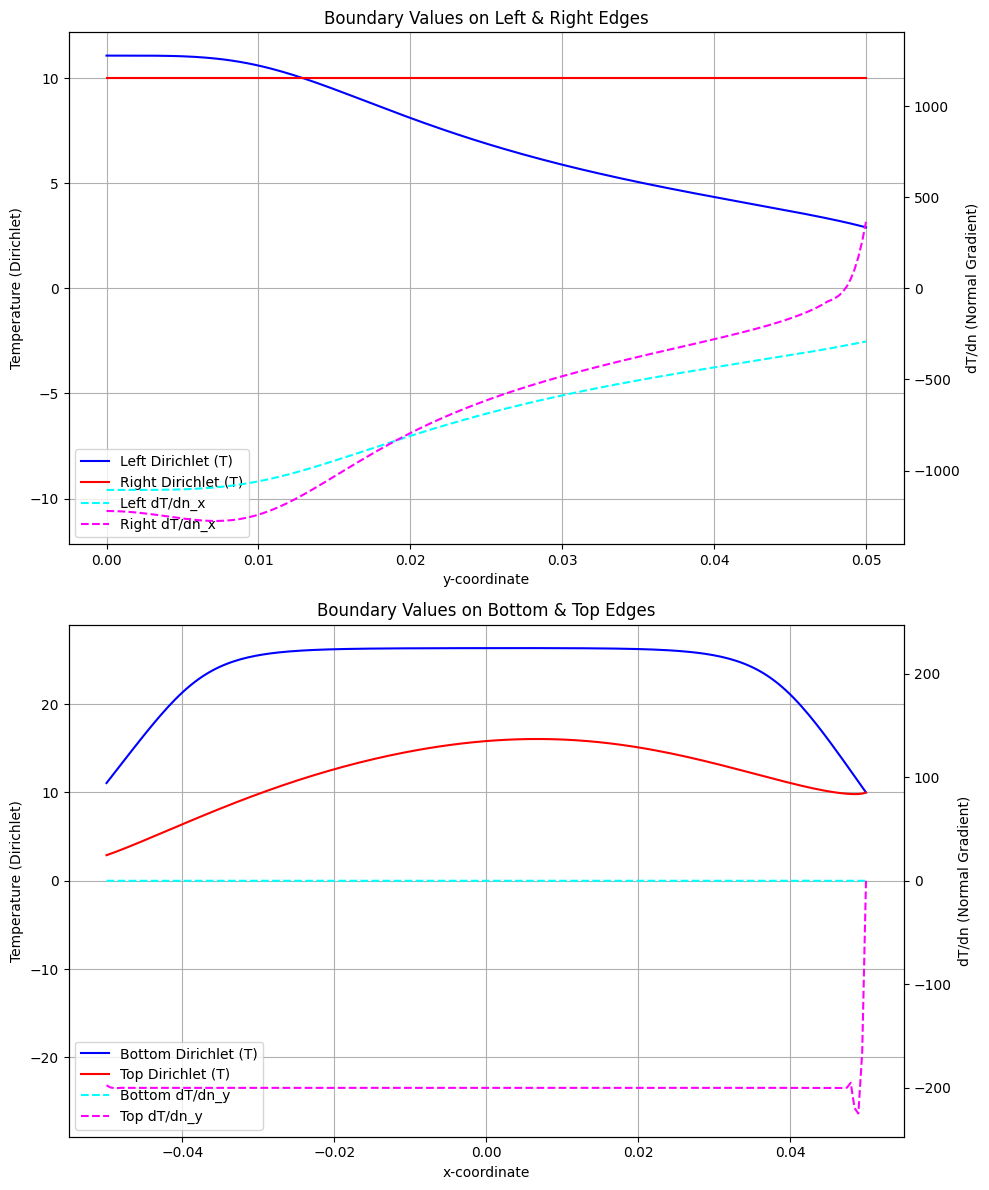

In [9]:
gfT = tp.solve()
if gfT:
    tp.draw_temperature_solution()
    tp.plot_boundary_conditions()

### Stationäre Wärmeverteilung homogener Dirichlet-Rand
Nun werden für die äusseren Ränder homogene Dirichlet-Randwerte $(T=0)$ angenommen.

In [29]:
tp.update_dirichlet_boundaries('outer_left|outer_top|outer_right')
gfT = tp.solve()
if gfT:
    tp.draw_temperature_solution()

Setting up H1 space with Dirichlet boundaries: 'outer_left|outer_top|outer_right'
Dirichlet boundaries updated to: 'outer_left|outer_top|outer_right'
Assembling BilinearForm a_T...
Assembling LinearForm f_T...
Solving thermal system...
Thermal system solved.
Drawing Temperature...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

### Lösen des Systems für Robin-Randwerte
Wie in Abschnitt {ref}`ref:RobinRand` beschrieben, lässt sich eine teilweise Isolation mit Robin-Randbedingungen modellieren. Je tiefer der Parameter $\alpha$, desto besser die Isolation.

In [1]:
tp.update_dirichlet_boundaries('')
alpha = 1
tp.add_robin_boundary_condition('outer_left|outer_top|outer_right', alpha, lamAir)
gfT = tp.solve()
if gfT:
    tp.draw_temperature_solution()

NameError: name 'tp' is not defined

> - Gute Isolation mit $\alpha=1$ (hohe Temperatur)

In [ ]:
alpha = 1000
tp.add_robin_boundary_condition('outer_left|outer_top|outer_right', alpha, lamAir)
gfT = tp.solve()
if gfT:
    tp.draw_temperature_solution()

> - Schlechte Isolation mit $\alpha=1000$ (fast gleiche Temperaturverteilung wie bei Dirichlet-Randbedingung)

Setting up H1 space with Dirichlet boundaries: ''
Dirichlet boundaries updated to: ''
Adding Neumann BC on 'outer_left' with given dT/dn
Adding Neumann BC on 'outer_top' with given dT/dn
Adding Neumann BC on 'outer_right' with given dT/dn
Assembling BilinearForm a_T...
Assembling LinearForm f_T...
Solving thermal system...
Thermal system solved.
Drawing Temperature...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Plotting boundary conditions...


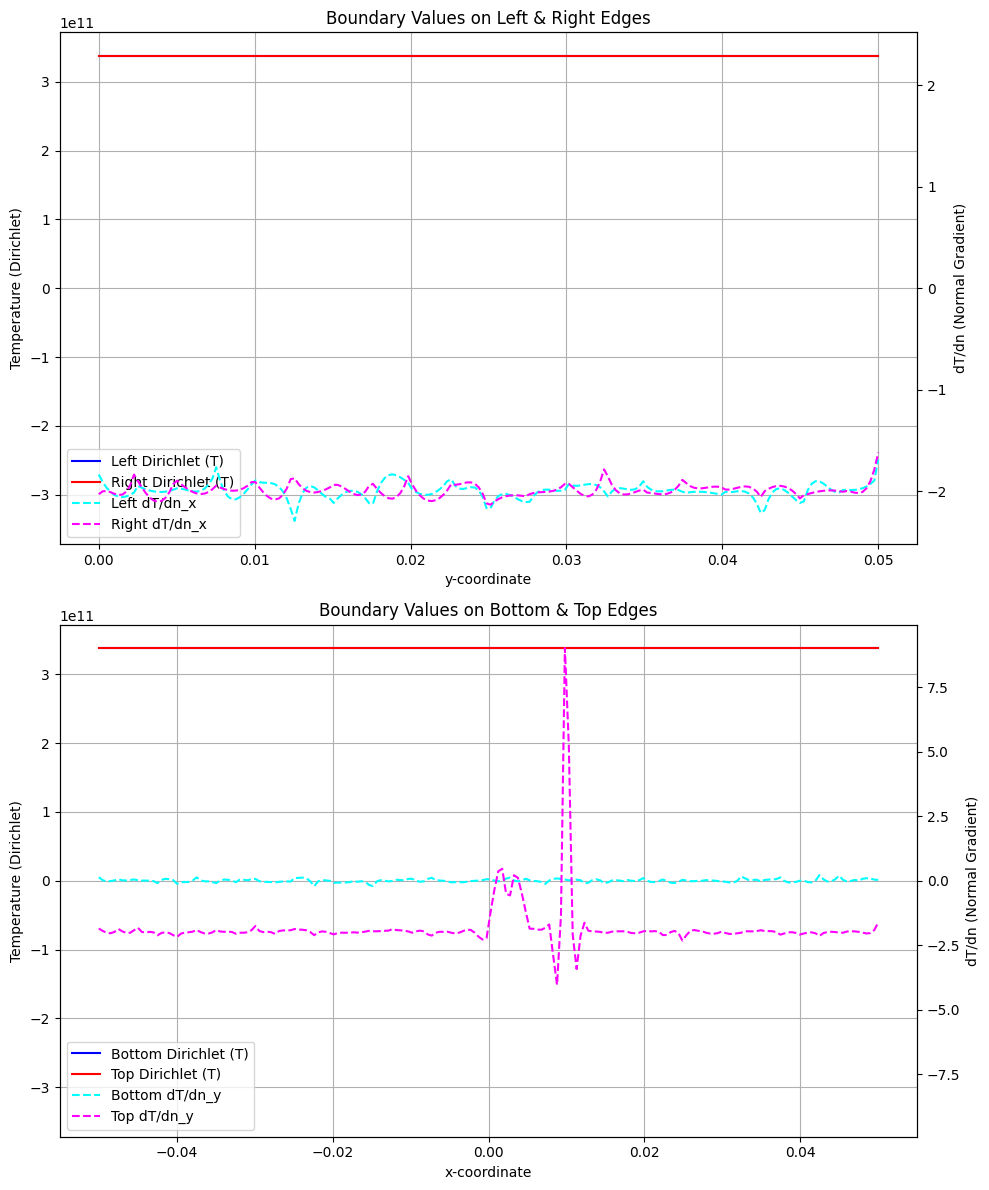

In [12]:
#tp = ThermalConductivityProblem(mesh, Qe, lam)
tp.update_dirichlet_boundaries('')
tp.add_neumann_boundary_condition('outer_left', -2, lamAir)
tp.add_neumann_boundary_condition('outer_top', -2, lamAir)
tp.add_neumann_boundary_condition('outer_right', -2, lamAir)
gfT = tp.solve()
if gfT:
    tp.draw_temperature_solution()
    tp.plot_boundary_conditions()